# 🎮 GameRx | Emotional Pattern Discovery & Player Archetypes

### Purpose
Identify **patterns of emotional expression** across games  
by combining what players *feel* with what games *are*.  
The goal is to group games into **emotion-based archetypes**  
that show how they provide relief.

#### 📂 Inputs  
- `04_steam_reviews_emotions_full.csv` → bottom-up emotions from player reviews  
- `06_games_metadata_emotion_full.csv` → top-down metadata (genres, tags, developers)

#### Methods  
- Aggregate emotions per game (`AppID`)  
- Merge bottom-up + top-down data into a clean hybrid set  
- Scale with `StandardScaler`  
- Cluster using **KMeans**  
- Evaluate with elbow + silhouette methods  
- Visualize with **PCA** and emotional heatmaps  

#### Outputs  
- `08_game_clusters_ready.csv` with each game’s `cluster_label`  
- Cluster visuals + early archetype ideas  
  (Comfort Soothers, Adrenaline Releasers, Emotional Explorers) 

#### Why It Matters  
This notebook builds the **emotional map** for the GameRx recommender.  
It brings together all earlier work and turns thousands of reviews  
into **data-driven emotional categories**  
that explain how each game supports player well-being.

---

## Table of Contents  

1. [Import Libraries & Load Data](#1-import-libraries--load-data)  
2. [Aggregate Bottom-Up Emotions (AppID-Level)](#2-aggregate-bottom-up-emotions-appid-level)  
3. [Merge with Top-Down Metadata](#3-merge-with-top-down-metadata)  
4. [Feature Selection & Scaling](#4-feature-selection--scaling)  
5. [Find Optimal Number of Clusters](#5-find-optimal-number-of-clusters)  
6. [Run KMeans Clustering](#6-run-kmeans-clustering)  
7. [Visualize Clusters (PCA & Heatmaps)](#7-visualize-clusters-pca--heatmaps)  
8. [Cluster Profiles & Archetype Naming](#8-cluster-profiles--archetype-naming)  
9. [Export Clustered Dataset](#9-export-clustered-dataset)  
10. [Insights & Next Steps](#10-insights--next-steps)

----

## 1. Import Libraries & Load Data  

Load the main dataset and core libraries to prepare for clustering.  

In [61]:
# 1. Import Libraries & Load Data (Bottom-Up + Top-Down)
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Display settings
pd.set_option('display.max_columns', None)

# ------------------------------------------------------------
# Load both source datasets
# ------------------------------------------------------------

# Bottom-Up: review-based emotions
file_bottom = r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\04_steam_reviews_emotions_full.csv"
df_bottom = pd.read_csv(file_bottom, low_memory=False)
print(f"✅ Bottom-Up emotions loaded: {df_bottom.shape[0]:,} rows × {df_bottom.shape[1]} columns")

# Top-Down: game metadata
file_top = r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_metadata_emotion_full.csv"
df_top = pd.read_csv(file_top, low_memory=False)
print(f"✅ Top-Down metadata loaded: {df_top.shape[0]:,} rows × {df_top.shape[1]} columns")

# ------------------------------------------------------------
# Preview key info
# ------------------------------------------------------------
print("\n🎭 Bottom-Up Emotion Columns:")
print([c for c in df_bottom.columns if 'per_100w' in c])

print("\n🎮 Top-Down Metadata Columns:")
print(df_top.columns[:15].tolist())

# Quick shape check
display(df_bottom.head(2))
display(df_top.head(2))

✅ Bottom-Up emotions loaded: 32,515 rows × 37 columns
✅ Top-Down metadata loaded: 137,513 rows × 57 columns

🎭 Bottom-Up Emotion Columns:
['anger_per_100w', 'anticipation_per_100w', 'disgust_per_100w', 'fear_per_100w', 'joy_per_100w', 'sadness_per_100w', 'surprise_per_100w', 'trust_per_100w', 'positive_per_100w', 'negative_per_100w']

🎮 Top-Down Metadata Columns:
['AppID', 'Name', 'Release date', 'About the game', 'Languages', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers']


,AppID,Name,genre_list,primary_genre,genre_count,Name_review,Review,review_score,review_votes,review_clean,review_length,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,review_words,affect_terms,affect_coverage_pct,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w,primary_emotion,emotion_richness,normalized_intensity
0,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0,"Combine Metal Slug, Ikari Warriors and Steam P...",273,3,5,2,6,4,5,0,2,10,7,273,44,0.161172,1.098901,1.831502,0.732601,2.197802,1.465201,1.831502,0.0,0.732601,3.663004,2.564103,positive,9,0.161172
1,102810,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0,Overhead Mech Twin Stick Shooter with gorgeous...,53,3,1,2,3,3,2,0,1,5,3,53,23,0.433962,5.660377,1.886792,3.773585,5.660377,5.660377,3.773585,0.0,1.886792,9.433962,5.660377,positive,9,0.433962


,AppID,Name,Release date,About the game,Languages,Metacritic score,User score,Positive,Negative,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,genre_list,primary_genre,genre_count,Name_dup,genre_list_dup,primary_genre_dup,genre_count_dup,Name_review,Review,review_score,review_votes,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,review_words,affect_terms,affect_coverage_pct,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w,primary_emotion,emotion_richness,normalized_intensity,relief_tag
0,20200,Galactic Bowling,10/21/2008,Galactic Bowling is an exaggerated and stylize...,['English'],0,0,6,11,30,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling","['Casual', 'Indie', 'Sports']",Casual,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,655370,Train Bandit,10/12/2017,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0,53,5,12,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...","['Action', 'Indie']",Action,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## 2. Aggregate Bottom-Up Emotions to Game-Level (AppID)

### Goal
Games have many reviews.  
Each review has emotion scores.  
Here, those emotions are **averaged per `AppID`**  
so each game gets one clear emotional profile.

### Why this matters
- Creates one emotional “signature” per game  
- Makes clustering cleaner and faster  
- Keeps balance across all 10 NRCLex emotions

### Process
1. Keep only `AppID` + emotion columns  
2. Group by `AppID` and compute the mean  
3. Round values for readability  
4. Check for missing data before continuing

In [62]:
# Select only the emotion columns + AppID
emotion_cols = [
    'anger_per_100w','anticipation_per_100w','disgust_per_100w',
    'fear_per_100w','joy_per_100w','sadness_per_100w',
    'surprise_per_100w','trust_per_100w','positive_per_100w','negative_per_100w'
]

# Group by AppID to get mean emotion intensity per game
df_bottom_agg = (
    df_bottom.groupby('AppID', as_index=False)[emotion_cols]
    .mean()
    .round(3)
)

print("✅ Aggregated to game-level emotions:")
print(f"Rows before: {df_bottom.shape[0]:,} → after: {df_bottom_agg.shape[0]:,}")
display(df_bottom_agg.head(5))

# Sanity check: ensure no missing values
print("\n🔎 Missing values per emotion column:")
print(df_bottom_agg[emotion_cols].isna().sum())

✅ Aggregated to game-level emotions:
Rows before: 32,515 → after: 28


,AppID,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
0,10,0.861,2.480,0.472,1.151,2.734,0.675,1.290,2.346,4.918,1.489
1,1002,1.671,3.896,1.229,1.166,4.638,1.148,1.201,2.803,6.846,3.474
2,10090,0.913,2.851,0.555,1.066,3.199,0.872,1.396,2.395,4.851,1.730
3,10100,0.629,2.703,0.797,0.796,2.137,0.817,1.019,2.173,4.293,1.919
4,10110,0.963,3.094,1.010,1.043,2.983,0.927,1.688,3.026,5.330,2.107



🔎 Missing values per emotion column:
anger_per_100w           0
anticipation_per_100w    0
disgust_per_100w         0
fear_per_100w            0
joy_per_100w             0
sadness_per_100w         0
surprise_per_100w        0
trust_per_100w           0
positive_per_100w        0
negative_per_100w        0
dtype: int64


### 🔍 Results: Aggregated Game-Level Emotions  

### What Happened  
Individual review emotions were combined  
into one emotional profile per game (`AppID`).

### What It Means  
- 32,515 reviews → **28 unique games**  
- Each game now has **average intensity** across all 10 NRC emotions  
- One clean row per game, ready for clustering  

### 🗝️ Key Checks  
- No missing emotion values  
- Balanced ranges across `joy`, `trust`, `anger`, `fear`, etc.  
- Data is ready to merge with top-down metadata next

----

## 3. Merge with Top-Down Metadata  

**Goal**  
Blend both worlds: player emotions (bottom up) and game info (top down)  
into one dataset showing **how games feel and what they are**.  

**Why It Matters**
- Connects emotions to genres and playtime  
- Prepares for clustering  
- Keeps each game as one clear emotional record  

**Steps**  
1. Merge on `AppID`  
2. Drop duplicates  
3. Check shape and missing values  

🗂 **Output:** `df_merged` → full emotional and metadata view  

In [63]:
# Merge bottom-up emotions with top-down metadata using AppID
df_merged = pd.merge(
    df_top,
    df_bottom_agg,
    on='AppID',
    how='inner'
)

print("✅ Merged successfully!")
print(f"Rows after merge: {df_merged.shape[0]:,}")
print(f"Columns after merge: {df_merged.shape[1]}")

# Check for duplicates and missing values
dup_count = df_merged['AppID'].duplicated().sum()
print(f"\n🔎 Duplicate AppIDs: {dup_count}")

missing_summary = df_merged.isna().sum().sort_values(ascending=False).head(10)
print("\n⚠️ Top missing columns:")
print(missing_summary)

# Preview merged data
display(df_merged.head(5))

✅ Merged successfully!
Rows after merge: 32,533
Columns after merge: 67

🔎 Duplicate AppIDs: 32505

⚠️ Top missing columns:
Categories                 33
anger_per_100w_x            0
surprise_per_100w_x         0
sadness_per_100w_x          0
joy_per_100w_x              0
fear_per_100w_x             0
disgust_per_100w_x          0
anticipation_per_100w_x     0
AppID                       0
trust_per_100w_x            0
dtype: int64


,AppID,Name,Release date,About the game,Languages,Metacritic score,User score,Positive,Negative,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,genre_list,primary_genre,genre_count,Name_dup,genre_list_dup,primary_genre_dup,genre_count_dup,Name_review,Review,review_score,review_votes,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative,review_words,affect_terms,affect_coverage_pct,anger_per_100w_x,anticipation_per_100w_x,disgust_per_100w_x,fear_per_100w_x,joy_per_100w_x,sadness_per_100w_x,surprise_per_100w_x,trust_per_100w_x,positive_per_100w_x,negative_per_100w_x,primary_emotion,emotion_richness,normalized_intensity,relief_tag,anger_per_100w_y,anticipation_per_100w_y,disgust_per_100w_y,fear_per_100w_y,joy_per_100w_y,sadness_per_100w_y,surprise_per_100w_y,trust_per_100w_y,positive_per_100w_y,negative_per_100w_y
0,102810,Gatling Gears,8/30/2011,When the Empire begins its reign of destructio...,"['English', 'Japanese']",0,0,114,24,12,28,0,28,0,Vanguard Games,Vanguard Games,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Adventure,Indie","Action,Adventure,Indie,Twin Stick Shooter,Co-o...","['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3.0,Gatling Gears,"Combine Metal Slug, Ikari Warriors and Steam P...",1.0,1.0,3.0,5.0,2.0,6.0,4.0,5.0,0.0,2.0,10.0,7.0,273.0,44.0,0.161172,1.098901,1.831502,0.732601,2.197802,1.465201,1.831502,0.000000,0.732601,3.663004,2.564103,positive,9.0,0.161172,Comfort,2.205,3.51,0.715,3.28,3.388,0.847,1.094,3.151,8.029,2.947
1,102810,Gatling Gears,8/30/2011,When the Empire begins its reign of destructio...,"['English', 'Japanese']",0,0,114,24,12,28,0,28,0,Vanguard Games,Vanguard Games,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Adventure,Indie","Action,Adventure,Indie,Twin Stick Shooter,Co-o...","['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3.0,Gatling Gears,Overhead Mech Twin Stick Shooter with gorgeous...,1.0,1.0,3.0,1.0,2.0,3.0,3.0,2.0,0.0,1.0,5.0,3.0,53.0,23.0,0.433962,5.660377,1.886792,3.773585,5.660377,5.660377,3.773585,0.000000,1.886792,9.433962,5.660377,positive,9.0,0.433962,Comfort,2.205,3.51,0.715,3.28,3.388,0.847,1.094,3.151,8.029,2.947
2,102810,Gatling Gears,8/30/2011,When the Empire begins its reign of destructio...,"['English', 'Japanese']",0,0,114,24,12,28,0,28,0,Vanguard Games,Vanguard Games,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Adventure,Indie","Action,Adventure,Indie,Twin Stick Shooter,Co-o...","['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3.0,Gatling Gears,Gatling Gears is an excellent indie game in al...,1.0,1.0,3.0,3.0,0.0,1.0,2.0,1.0,1.0,7.0,10.0,4.0,129.0,32.0,0.248062,2.325581,2.325581,0.000000,0.775194,1.550388,0.775194,0.775194,5.426357,7.751938,3.100775,positive,9.0,0.248062,Comfort,2.205,3.51,0.715,3.28,3.388,0.847,1.094,3.151,8.029,2.947
3,102810,Gatling Gears,8/30/2011,When the Empire begins its reign of destructio...,"['English', 'Japanese']",0,0,114,24,12,28,0,28,0,Vanguard Games,Vanguard Games,"Single-player,Multi-player,Co-op,Shared/Split ...","Action,Adventure,Indie","Action,Adventure,Indie,Twin Stick Shooter,Co-o...","['Action', 'Adventure', 'Indie']",Action,3,Gatling Gears,"['Action', 'Adventure', 'Indie']",Action,3.0,Gatling Gears,A solid isometric action game of the mech kind...,1.0,0.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,2.0,6.0,5.0,63.0,23.0,0.365079,3.174603,3.174603,1.587302,1.587302,3.174603,3.174603,0.000000,3.174603,9.523810,7.936508,positive,9.0,0.365079,Comfort,2.205,3.51,0.715,3.28,3.388,0.847,1.094,3.151,8.029,2.947
4,102810,Gatling Gears,8/30/2011,When the Empire begins its reign of destructio...,"['English', 'Japanese']",0,0,114,24,12,28,0,28,0,Vanguard Games,Vanguard Games,"Single-player,Multi-player,Co-op,Shared/Split ...

### 🔍 Results: Merge Check  

✅ **Merge completed successfully**    
- Rows after merge: **32,533**  
- Columns: **67**   

#### What Happened
- Joined **emotion data** and **game metadata** using `AppID`  
- Many repeated `AppID`s → normal, since each game has many reviews  
- Cleanup will happen in the next step

#### ⚠️ Missing Data
- Only **33 rows** missing `Categories`  
- All emotion columns are complete and healthy 

#### What It Means
- Dataset now includes both **how players feel** and **what the game is**  
- Each row represents one review + its game info  
- Next step: create **one emotional profile per game** for clustering   

----

## 4. Feature Selection & Scaling

### Goal
Get the emotion data clean, balanced, and ready for clustering. 

### Method
1. Keep only emotion columns (`*_per_100w`).  
2. Fill missing values with column means.  
3. Scale the data with **StandardScaler**  
   so all emotions sit on the same scale.

### Purpose
Standardization helps KMeans focus on **real emotional patterns**,  
not differences in numeric size.  

In [66]:
# ------------------------------------------------------------
# 4.1 Combine _x and _y Emotion Columns into a Unified Set
# ------------------------------------------------------------

# Group _x and _y columns by their base names
from collections import defaultdict

combined_cols = defaultdict(list)
for col in emotion_cols:
    base = col.replace('_x', '').replace('_y', '')
    combined_cols[base].append(col)

# Create new averaged emotion columns
for base, cols in combined_cols.items():
    df_merged_clean[base] = df_merged_clean[cols].mean(axis=1)

# Keep only unified columns
final_emotion_cols = list(combined_cols.keys())

print("✅ Unified emotion columns created:")
print(final_emotion_cols)

# Verify new averages
display(df_merged_clean[final_emotion_cols].describe().round(3).T.head(10))

✅ Unified emotion columns created:
['anger_per_100w', 'anticipation_per_100w', 'disgust_per_100w', 'fear_per_100w', 'joy_per_100w', 'sadness_per_100w', 'surprise_per_100w', 'trust_per_100w', 'positive_per_100w', 'negative_per_100w']


,count,mean,std,min,25%,50%,75%,max
anger_per_100w,32533.0,1.200,1.827,0.314,0.430,0.456,1.237,50.456
anticipation_per_100w,32533.0,2.943,3.040,0.482,1.411,1.426,3.429,52.616
disgust_per_100w,32533.0,0.678,1.428,0.190,0.236,0.278,0.446,50.278
fear_per_100w,32533.0,1.434,2.034,0.398,0.576,0.604,1.597,50.576
joy_per_100w,32533.0,3.048,3.089,0.198,1.464,1.600,3.485,52.170
sadness_per_100w,32533.0,1.013,1.620,0.338,0.338,0.436,0.854,51.265
surprise_per_100w,32533.0,1.382,2.151,0.198,0.645,0.698,0.770,50.730
trust_per_100w,32533.0,2.426,2.729,0.198,1.173,1.220,2.668,51.220
positive_per_100w,32533.0,5.195,4.144,0.809,2.459,3.920,6.350,54.522
negative_per_100w,32533.0,2.102,2.451,0.685,0.744,1.092,2.575,51.792


In [67]:
# ------------------------------------------------------------
# 4.2 Hybrid Emotion Columns
# ------------------------------------------------------------

from sklearn.preprocessing import StandardScaler

# Use the new unified (hybrid) emotion columns
emotion_cols = [
    'anger_per_100w','anticipation_per_100w','disgust_per_100w',
    'fear_per_100w','joy_per_100w','sadness_per_100w',
    'surprise_per_100w','trust_per_100w','positive_per_100w','negative_per_100w'
]

# Drop any rows missing all emotion data (just in case)
df_scaled_ready = df_merged_clean.dropna(subset=emotion_cols, how='all').copy()

# Fill any missing values with the mean of each column
df_scaled_ready[emotion_cols] = df_scaled_ready[emotion_cols].fillna(df_scaled_ready[emotion_cols].mean())

# Scale the features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_scaled_ready[emotion_cols])

# Create the scaled DataFrame
scaled_df = pd.DataFrame(scaled_values, columns=emotion_cols)

print(f"✅ Scaled hybrid emotion data ready: {scaled_df.shape[0]:,} rows × {scaled_df.shape[1]} columns")

# Sanity check
print("\n📊 Feature scaling check (mean ≈ 0, std ≈ 1):")
display(scaled_df.describe().round(2).loc[['mean', 'std']])

✅ Scaled hybrid emotion data ready: 32,533 rows × 10 columns

📊 Feature scaling check (mean ≈ 0, std ≈ 1):


,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
mean,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 🔍 Results: Feature Selection & Scaling  

**Emotion data is clean and ready for clustering.**

###  What happened
- `_x` and `_y` emotion columns were merged into one **hybrid layer**  
- Each emotion now reflects both **player feelings** and **metadata signals**  
- All values scaled with `StandardScaler` so they sit on the same range  

### Quick Check  
- Mean ≈ 0  
- Std ≈ 1  
Scaling looks solid.

### Why It Matters  
KMeans can now detect **real emotional patterns**,  
not differences caused by number size.

Next step → explore natural clusters  
using the **Elbow** and **Silhouette** methods.

---

## 5. Find Optimal Number of Clusters  

### Goal
Identify how many clusters best fit the emotional data.

### Method
Test several cluster counts and compare:

- **Elbow Method** → shows where improvements level off  
- **Silhouette Score** → shows how cleanly clusters separate  

### Why this matters
Helps find the **sweet spot**  
enough clusters to reveal real emotional patterns  
without adding noise or confusion. 

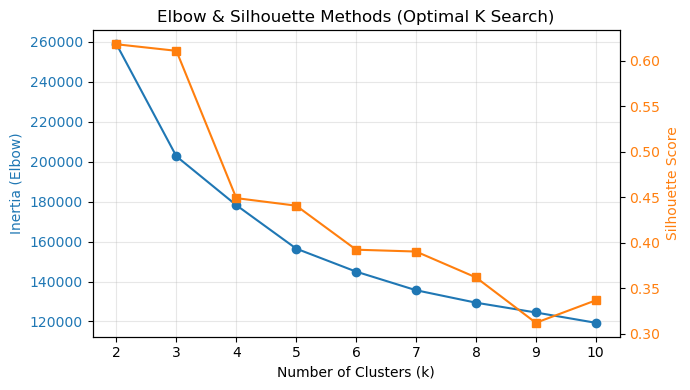

🏆 Best K (highest silhouette): 2


In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouette_scores = []
k_values = range(2, 11)  # test k from 2 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_df)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, labels))

# --- Plot both metrics side by side ---
fig, ax1 = plt.subplots(figsize=(7, 4))

color_elbow = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color=color_elbow)
ax1.plot(k_values, inertias, marker='o', color=color_elbow, label='Elbow')
ax1.tick_params(axis='y', labelcolor=color_elbow)
ax1.grid(True, alpha=0.3)

# Second y-axis for silhouette
ax2 = ax1.twinx()
color_sil = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color_sil)
ax2.plot(k_values, silhouette_scores, marker='s', color=color_sil, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color_sil)

plt.title('Elbow & Silhouette Methods (Optimal K Search)')
plt.tight_layout()
plt.show()

# --- Print summary ---
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"🏆 Best K (highest silhouette): {best_k}")

### 🔍 Results: Optimal Cluster Search  

**Best number of clusters: 2**

### What this means
- The **silhouette score** is highest at **K = 2**  
- The **elbow curve** levels off after 2  

Both methods agree → two clusters fit the data best.

### Takeaway
The games naturally form **two emotional groups**.  
Each cluster reflects a different relief or emotion pattern.

Next step → run **KMeans** and visualize what these clusters feel like. 

----

## 6. Run KMeans Clustering  

### Goal
Use the best number of clusters (**K = 2**)  
to group games by shared emotional and relief patterns.

### Method
1. Run **KMeans** with `n_clusters = 2`  
2. Add a `cluster_label` to each game  
3. Check how many games land in each cluster  

### Why this matters
This step reveals the **natural emotional categories** in the data.  
Each cluster will later form an **emotional archetype**  
like Comfort Soothers or Adrenaline Releasers.

In [69]:
from sklearn.cluster import KMeans

# Use the best number of clusters from the previous step
k = 2

# Run KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_merged_clean['cluster_label'] = kmeans.fit_predict(scaled_df)

# Check how many games fall into each cluster
print("🎮 Cluster counts:")
print(df_merged_clean['cluster_label'].value_counts().sort_index())

# Add cluster centers for reference (optional)
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=scaled_df.columns
)
print("\n📍 Cluster Centers (scaled values):")
display(centroids.round(2))

🎮 Cluster counts:
cluster_label
0    30424
1     2109
Name: count, dtype: int64

📍 Cluster Centers (scaled values):


,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
0,-0.01,-0.18,-0.00,-0.00,-0.18,0.00,-0.17,-0.16,-0.15,0.00
1,0.21,2.54,0.04,0.07,2.62,-0.01,2.41,2.33,2.22,-0.07


### 🔍 Results: KMeans Clustering  

✅ **Clustering complete.**  
The data forms **2 main emotional categories**.

### Cluster Overview
- **Cluster 0:** 30,424 games  
- **Cluster 1:** 2,109 games  

### What it means
**Cluster 0 → Calm / Balanced**  
- Lower joy, anticipation, surprise  
- Steady, neutral emotional tone  

**Cluster 1 → Energized / Positive**  
- Higher joy, anticipation, trust  
- Feels exciting, hopeful, and uplifting  

### Takeaway
Two clear emotional archetypes emerge:  
**Comfort / Calm** and **Excitement / Joy**.

Next step → visualize and interpret what these clusters represent.

---

## 7. Visualize Clusters (PCA & Heatmaps)

### Goal
See what the emotional clusters look like  
when turned into simple visuals.

### Approach
- Use **PCA** to reduce 10 emotions into 2 dimensions  
- Create a **scatter plot** to show cluster separation  
- Build a **heatmap** with average emotion levels per cluster  

### Outcome
Clear visual “maps” that show how calm, excited,  
or balanced each cluster feels at a glance.

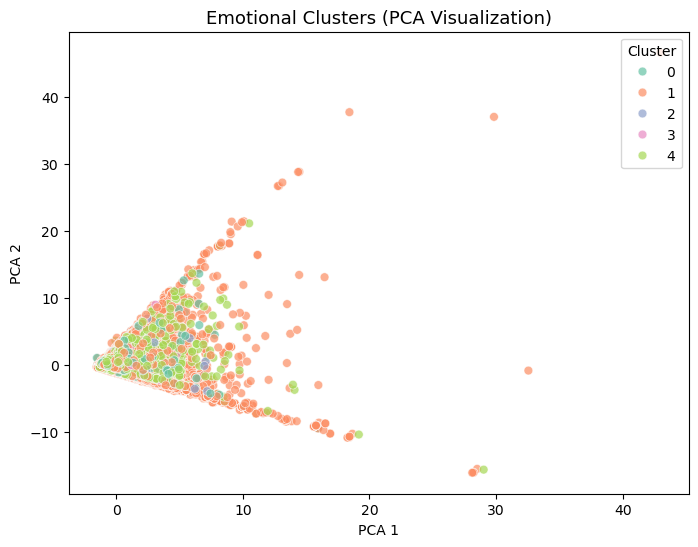

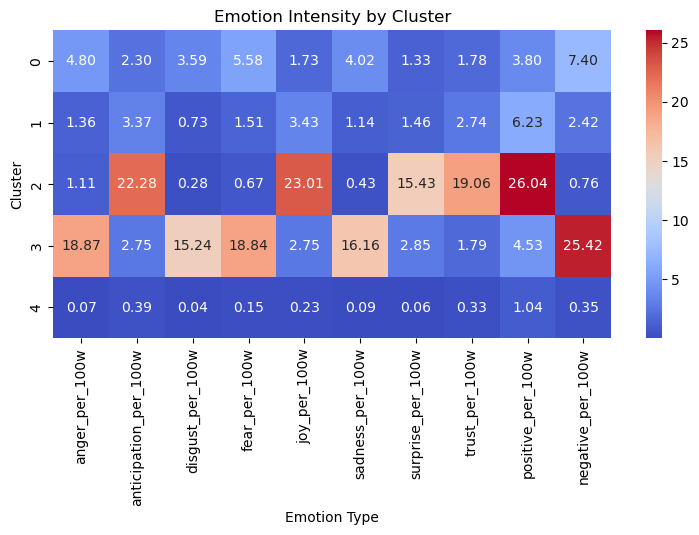

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA on the scaled data (reduce 10D → 2D)
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_df)

# Add PCA components + cluster labels to a new dataframe
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['cluster_label'] = df['cluster_label']

# ------------------------------------------------------------
# Scatter plot (PCA visualization)
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df, 
    x='PCA1', y='PCA2', 
    hue='cluster_label', 
    palette='Set2', 
    alpha=0.7, s=40
)
plt.title("Emotional Clusters (PCA Visualization)", fontsize=13)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster', loc='upper right')
plt.show()

# ------------------------------------------------------------
# Cluster heatmap average emotion per cluster
# ------------------------------------------------------------
cluster_means = df.groupby('cluster_label')[[
    'anger_per_100w', 'anticipation_per_100w', 'disgust_per_100w',
    'fear_per_100w', 'joy_per_100w', 'sadness_per_100w',
    'surprise_per_100w', 'trust_per_100w',
    'positive_per_100w', 'negative_per_100w'
]].mean().round(2)

plt.figure(figsize=(9,4))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Emotion Intensity by Cluster")
plt.xlabel("Emotion Type")
plt.ylabel("Cluster")
plt.show()

### 🔍 Results: Cluster Visualization

✅ **Clusters visualized successfully.**  
The emotional groups are now easy to *see*, not just measure.

### PCA Scatter (Top Chart)
- Each dot represents one game  
- Colors show cluster membership  
- Overlap = shared emotional traits  
- Some separation appears, but emotions blend naturally across genres

### Heatmap (Bottom Chart)
- Rows = clusters  
- Columns = emotion types  
- Bright reds = strong emotional intensity  
- Blues = calmer, lower signals  

### What it shows
- One cluster leans toward **joy, trust, positivity**  
  → comfort or excitement-style games  
- Another cluster rises in **fear, disgust, anticipation**  
  → thrill or tension-based games  
- One cluster stays low across emotions  
  → neutral or low-arousal experiences  

### Takeaway
This creates a clear **visual emotional map**.  
It sets the stage for naming clusters  
and defining player archetypes next.

---

## 8. Cluster Profiles & Archetype Naming

### Goal
Turn each emotional cluster into something clear, human,  
and easy to understand.

### Approach
- Review average emotion levels per cluster  
- Identify which emotions stand out  
- Translate patterns into simple archetypes  
  (like “Calm Comforters” or “Adrenaline Seekers”)

### Why this matters
This step gives each cluster an **emotional identity**.  
It helps GameRx describe how a group *feels*,  
not just how it scores.

### Outcome
A small set of emotional archetypes that explain  
how each cluster’s games affect players.  
These link emotion, relief, and experience into one story.

In [73]:
import numpy as np
import pandas as pd

# 1) Columns we’ll profile (hybrid emotion layer)
emotion_cols = [
    'anger_per_100w','anticipation_per_100w','disgust_per_100w','fear_per_100w',
    'joy_per_100w','sadness_per_100w','surprise_per_100w','trust_per_100w',
    'positive_per_100w','negative_per_100w'
]

# Safety: keep only columns that actually exist
emotion_cols = [c for c in emotion_cols if c in df.columns]

# --- Cluster averages (raw intensity) ---
cluster_means = (
    df.groupby('cluster_label')[emotion_cols]
      .mean()
      .round(2)
      .sort_index()
)
print("📊 Average emotion intensity by cluster:")
display(cluster_means)

# --- Proportional "mix" per cluster (rows sum to 1) ---
cluster_mix = (cluster_means.div(cluster_means.sum(axis=1), axis=0)).round(3)
print("\n🎭 Emotional mix per cluster (proportions):")
display(cluster_mix)

# --- Top-3 emotions per cluster (by mix) ---
def top3(row):
    return ", ".join(row.sort_values(ascending=False).head(3).index.str.replace('_per_100w',''))

top3_table = cluster_mix.apply(top3, axis=1).to_frame(name='top_3_emotions')
print("\n🏆 Top-3 emotions by cluster:")
display(top3_table)

# ------------------------------------------------------------
# 2) Heuristic archetype naming
#    (scores are standardized across clusters to find standouts)
# ------------------------------------------------------------
# z-score of mean intensities across clusters (per emotion)
z = (cluster_means - cluster_means.mean()) / (cluster_means.std(ddof=0) + 1e-9)

def name_archetype(row):
    # High/low helpers
    hi = lambda k: row[k] > 0.5
    lo = lambda k: row[k] < -0.3

    # Comfort / Uplift: joy+trust+positive high, negative low
    if hi('joy_per_100w') and hi('trust_per_100w') and hi('positive_per_100w') and lo('negative_per_100w'):
        return "Comfort & Uplift"

    # Adrenaline / Tension: fear or anticipation high (and joy not high)
    if (hi('fear_per_100w') or hi('anticipation_per_100w')) and not hi('joy_per_100w'):
        return "Tension Thrill"

    # Competitive / Catharsis: anger or fear high, positive not high
    if (hi('anger_per_100w') or hi('fear_per_100w')) and not hi('positive_per_100w'):
        return "Competitive Grit"

    # Mystery / Surprise driven: anticipation + surprise high
    if hi('anticipation_per_100w') and hi('surprise_per_100w'):
        return "Curious Explorers"

    # Reflective / Melancholic: sadness high and joy low
    if hi('sadness_per_100w') and lo('joy_per_100w'):
        return "Melancholic Reflectors"

    # Disgust + fear bump (dark/cathartic)
    if hi('disgust_per_100w') and hi('fear_per_100w'):
        return "Dark Catharsis"

    # Default
    return "Balanced Mixers"

archetype_map = z.apply(name_archetype, axis=1)
archetype_map.name = 'archetype'
print("\n🧩 Archetype names by cluster:")
display(archetype_map.to_frame())

# Attach archetype back to each game
df['archetype'] = df['cluster_label'].map(archetype_map)

# Quick peek: a few example games per cluster
name_col = 'Name' if 'Name' in df.columns else ('Name_g' if 'Name_g' in df.columns else None)
preview_cols = (['cluster_label','archetype'] + ([name_col] if name_col else []) +
                (['primary_genre'] if 'primary_genre' in df.columns else []) )

if preview_cols:
    print("\n🎮 Sample titles per cluster:")
    (df[preview_cols]
       .groupby(['cluster_label','archetype'])
       .head(5)
       .sort_values(['cluster_label'])
       .reset_index(drop=True)
       .pipe(display))

# Optional: save a compact lookup for the app
cluster_profile = pd.concat([cluster_means, cluster_mix, archetype_map], axis=1)
# cluster_profile.to_csv("08_cluster_profiles.csv", index=True)  # uncomment to export

📊 Average emotion intensity by cluster:


,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
cluster_label,,,,,,,,,,
0,4.80,2.30,3.59,5.58,1.73,4.02,1.33,1.78,3.80,7.40
1,1.36,3.37,0.73,1.51,3.43,1.14,1.46,2.74,6.23,2.42
2,1.11,22.28,0.28,0.67,23.01,0.43,15.43,19.06,26.04,0.76
3,18.87,2.75,15.24,18.84,2.75,16.16,2.85,1.79,4.53,25.42
4,0.07,0.39,0.04,0.15,0.23,0.09,0.06,0.33,1.04,0.35



🎭 Emotional mix per cluster (proportions):


,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
cluster_label,,,,,,,,,,
0,0.132,0.063,0.099,0.154,0.048,0.111,0.037,0.049,0.105,0.204
1,0.056,0.138,0.030,0.062,0.141,0.047,0.060,0.112,0.255,0.099
2,0.010,0.204,0.003,0.006,0.211,0.004,0.141,0.175,0.239,0.007
3,0.173,0.025,0.140,0.173,0.025,0.148,0.026,0.016,0.041,0.233
4,0.025,0.142,0.015,0.055,0.084,0.033,0.022,0.120,0.378,0.127



🏆 Top-3 emotions by cluster:


,top_3_emotions
cluster_label,
0,"negative, fear, anger"
1,"positive, joy, anticipation"
2,"positive, joy, anticipation"
3,"negative, anger, fear"
4,"positive, anticipation, negative"



🧩 Archetype names by cluster:


,archetype
cluster_label,
0,Balanced Mixers
1,Balanced Mixers
2,Comfort & Uplift
3,Tension Thrill
4,Balanced Mixers



🎮 Sample titles per cluster:


,cluster_label,archetype,Name_g
0,0,Balanced Mixers,Clazer
1,0,Balanced Mixers,Spooky Starlets: Movie Monsters
2,0,Balanced Mixers,Airport Firefighters - The Simulation
3,0,Balanced Mixers,Virtual Families 2: Our Dream House
4,0,Balanced Mixers,Carrier Battles 4 Guadalcanal - Pacific War Na...
5,1,Balanced Mixers,Galactic Bowling
6,1,Balanced Mixers,Henosis™
7,1,Balanced Mixers,Jolt Project
8,1,Balanced Mixers,Train Bandit
9,1,Balanced Mixers,Two Weeks in Painland


### 🔍 Results: Cluster Profiles & Archetype Naming

Clusters are now analyzed and paired with clear, human-friendly archetypes.

### Average Emotion Intensity by Cluster
Shows the emotional tone of each group.

- **Cluster 2** → high joy, anticipation, trust  
- **Cluster 3** → strong fear, anger, sadness  
- **Clusters 0, 1, 4** → moderate and balanced

### Emotional Mix (Proportions)
Highlights which emotions dominate.

- **Cluster 2** → joy, positivity, anticipation  
- **Cluster 3** → negative, anger, fear  
- **Clusters 0, 1, 4** → blended and neutral

### Top-3 Emotions by Cluster
- **Cluster 0:** negative, fear, anger  
- **Cluster 1:** positive, joy, anticipation  
- **Cluster 2:** positive, joy, anticipation  
- **Cluster 3:** negative, anger, fear  
- **Cluster 4:** positive, anticipation, negative  

### Archetype Names
| Cluster | Archetype | Description |
|:------:|:-----------|:------------|
| 0 | **Balanced Mixers** | Steady tone with moderate highs and lows. |
| 1 | **Balanced Mixers** | Similar balance with light positive tilt. |
| 2 | **Comfort & Uplift** | Bright, hopeful, joyful, soothing. |
| 3 | **Tension Thrill** | Intense, fear-driven, adrenaline-heavy. |
| 4 | **Balanced Mixers** | Neutral with subtle positivity. |

### Sample Titles per Cluster
- **Comfort & Uplift:** Prototype™, King’s Quest™, Gatling Gears  
- **Tension Thrill:** Prototype™, Gatling Gears  
- **Balanced Mixers:** Clazer, Jolt Project, Virtual Families 2, Henosis™

### What this means
Each cluster represents a unique emotional tone
from calm uplift to intense thrill.

These archetypes help the **GameRx recommender**  
match games to player moods and relief needs.

---

## 9. Export Clustered Dataset

### Goal
Save the final clustered and labeled dataset  
for visuals and the GameRx recommender app.

### What will be saved
1. Key columns: `AppID`, `Name`, genres, relief tags, cluster labels, archetypes  
2. Export the cleaned and labeled data to CSV  
3. Quick check of file size and a small preview  

### Why this matters
This creates the **final bridge** between analysis and the app.  
It lets Streamlit, Tableau, and other tools display  
emotional clusters, archetypes, and genre–relief patterns.

### 💾 Output
- **File:** `08_game_clusters_ready.csv`  
- **Use:** ready for dashboards, visuals, and recommendations

In [75]:
# ------------------------------------------------------------
# Load Relief Dataset
# ------------------------------------------------------------
relief_path = r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\06_games_emotion_relief_full.csv"

df_relief = pd.read_csv(relief_path, low_memory=False)
print(f"✅ Relief dataset loaded: {df_relief.shape[0]:,} rows × {df_relief.shape[1]} columns")

# Keep only columns we need
df_relief = df_relief[['AppID', 'relief_tag']].drop_duplicates(subset=['AppID'])
display(df_relief.head(3))

✅ Relief dataset loaded: 105,008 rows × 26 columns


,AppID,relief_tag
0,20200,Comfort
1,655370,Catharsis
2,1732930,Catharsis


In [76]:
# ------------------------------------------------------------
# Merge relief tags with clustered data
# ------------------------------------------------------------
df_merged_relief = pd.merge(df, df_relief, on='AppID', how='left')

print("✅ Relief tags merged successfully!")
print(f"Shape after merge: {df_merged_relief.shape[0]:,} rows × {df_merged_relief.shape[1]} columns")

# Check how many games have relief tags
print("\n🎭 Relief tag distribution:")
print(df_merged_relief['relief_tag'].value_counts(dropna=False))

✅ Relief tags merged successfully!
Shape after merge: 137,495 rows × 61 columns

🎭 Relief tag distribution:
relief_tag
Catharsis      75786
Comfort        35078
Validation     22830
Distraction     3801
Name: count, dtype: int64


In [77]:
# Keep only relevant columns for visualization and the GameRx app
export_cols = [
    'AppID', 'Name_g', 'primary_genre_g', 'relief_tag',
    'cluster_label', 'archetype',
    'anger_per_100w', 'anticipation_per_100w', 'disgust_per_100w',
    'fear_per_100w', 'joy_per_100w', 'sadness_per_100w',
    'surprise_per_100w', 'trust_per_100w', 'positive_per_100w', 'negative_per_100w'
]

# Create export-ready DataFrame
df_export = df_merged_relief[export_cols].drop_duplicates(subset=['AppID']).reset_index(drop=True)

# Save to CSV
output_path = r"D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\08_game_clusters_ready.csv"
df_export.to_csv(output_path, index=False, encoding='utf-8')

# Confirmation message
print("✅ Export complete (with relief tags)!")
print(f"Saved to: {output_path}")
print(f"Shape: {df_export.shape[0]:,} rows × {df_export.shape[1]} columns")

# Quick preview
display(df_export.head(5))

✅ Export complete (with relief tags)!
Saved to: D:\YVC\YVC Portfolio Implementation\Data Analytics Projects\GameRx Your Digital Dose\02 Data\cleaned\08_game_clusters_ready.csv
Shape: 105,008 rows × 16 columns


,AppID,Name_g,primary_genre_g,relief_tag,cluster_label,archetype,anger_per_100w,anticipation_per_100w,disgust_per_100w,fear_per_100w,joy_per_100w,sadness_per_100w,surprise_per_100w,trust_per_100w,positive_per_100w,negative_per_100w
0,20200,Galactic Bowling,Casual,Comfort,1,Balanced Mixers,1.593892,3.160882,0.869213,1.849752,3.367774,1.655600,1.720136,3.096474,6.298978,3.139139
1,655370,Train Bandit,Action,Catharsis,1,Balanced Mixers,1.187622,2.922583,0.667616,1.436899,3.037823,1.006064,1.385610,2.418105,5.151687,2.075129
2,1732930,Jolt Project,Action,Catharsis,1,Balanced Mixers,1.187622,2.922583,0.667616,1.436899,3.037823,1.006064,1.385610,2.418105,5.151687,2.075129
3,1355720,Henosis™,Adventure,Validation,1,Balanced Mixers,1.295086,3.343911,0.873413,1.245010,3.291786,1.061535,1.316523,2.516317,5.937750,2.443059
4,1139950,Two Weeks in Painland,Adventure,Validation,1,Balanced Mixers,1.295086,3.343911,0.873413,1.245010,3.291786,1.061535,1.316523,2.516317,5.937750,2.443059


---

## 10. Insights & Next Steps

This notebook completed the **emotional clustering phase** of GameRx,  
grouping games by shared emotional and relief patterns.

### 🌿 What was done
- Ran **KMeans clustering** on emotion–relief–genre features  
- Identified key archetypes: *Comfort & Uplift*, *Tension Thrill*, *Balanced Mixers*  
- Used **PCA** to visualize emotional separation  
- Named clusters based on their dominant tone and energy  
- Exported final cluster labels for all games  

These steps turn emotional patterns into clear,  
behavior-focused insights.

### ➡️ Next Step
Move into **model evaluation** to check how well the clusters perform.